<h1>Data Science | Trabalho final - 1ª entrega | Isadora Figueiredo e Pedro Ferreira</h1>

<h2>Objetivo:</h2>
<p>Construir um modelo de predição de desempenho dos jogadores da NBA para a temporada 24-25.</p>

In [1]:
#Bibliotecas utilizadas
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

In [2]:
# Carregando a base de dados
dados = pd.read_csv('base.csv')

df = dados

# Exibir primeiras linhas 
df.head(10)

,Rk,Player,PTS,Date,Age,Team,Unnamed: 6,Opp,Result,GS,...,STL,BLK,TOV,PF,PTS.1,GmSc,BPM,+/-,Pos.,Player-additional
0,1,Stephen Curry,62,2021-01-03,32-295,GSW,NaN,POR,W 137-122,*,...,0,0,5,0,62,46.8,18.6,20,G,curryst01
1,2,Stephen Curry,60,2024-02-03,35-326,GSW,@,ATL,L 134-141 (OT),*,...,0,1,2,1,60,45.5,22.4,-1,G,curryst01
2,3,Stephen Curry,57,2021-02-06,32-329,GSW,@,DAL,L 132-134,*,...,1,0,3,3,57,43.8,18.3,7,G,curryst01
3,4,Stephen Curry,54,2013-02-27,24-350,GSW,@,NYK,L 105-109,*,...,3,0,4,3,54,46.1,23.0,-4,G,curryst01
4,5,Stephen Curry,53,2015-10-31,27-231,GSW,@,NOP,W 134-120,*,...,4,0,2,3,53,49.2,27.8,16,G,curryst01
5,6,Stephen Curry,53,2021-04-12,33-029,GSW,NaN,DEN,W 116-107,*,...,0,0,5,3,53,39.8,20.9,16,G,curryst01
6,7,Stephen Curry,51,2015-02-04,26-327,GSW,NaN,DAL,W 128-114,*,...,1,0,3,3,51,39.2,19.5,0,G,curryst01
7,8,Stephen Curry,51,2016-02-03,27-326,GSW,@,WAS,W 134-121,*,...,3,0,7,3,51,37.3,17.6,20,G,curryst01
8,9,Stephen Curry,51,2016-02-25,27-348,GSW,@,ORL,W 130-114,*,...,0,1,5,1,51,43.1,24.9,11,G,curryst01
9,10,Stephen Curry,51,2018-10-24,30-224,GSW,NaN,WAS,W 144-122,*,...,0,1,2,1,51,41.8,23.0,19,G,curryst01


In [3]:
# Quantidade de linhas e colunas
linhas, colunas = df.shape

print(f"{linhas} linhas e {colunas} colunas.")

956 linhas e 38 colunas.


In [4]:
# Deletar linha duplicada
df.drop_duplicates(inplace=True)

# Nome colunas
print(df.columns)

Index(['Rk', 'Player', 'PTS', 'Date', 'Age', 'Team', 'Unnamed: 6', 'Opp',
       'Result', 'GS', 'MP', 'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', '3P',
       '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TS%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS.1', 'GmSc', 'BPM', '+/-', 'Pos.',
       'Player-additional'],
      dtype='object')


In [5]:
# Verificar os tipos de dados de cada coluna
print(df.dtypes)

Rk                     int64
Player                object
PTS                    int64
Date                  object
Age                   object
Team                  object
Unnamed: 6            object
Opp                   object
Result                object
GS                    object
MP                     int64
FG                     int64
FGA                    int64
FG%                  float64
2P                     int64
2PA                    int64
2P%                  float64
3P                     int64
3PA                    int64
3P%                  float64
FT                     int64
FTA                    int64
FT%                  float64
TS%                  float64
ORB                    int64
DRB                    int64
TRB                    int64
AST                    int64
STL                    int64
BLK                    int64
TOV                    int64
PF                     int64
PTS.1                  int64
GmSc                 float64
BPM           

In [6]:
# Converter coluna 
df['Date'] = pd.to_datetime(df['Date'])  

 
# Ordenar crescente
df = df.sort_values(by='Date')

# Arredondar a coluna Age
df["Age"] = df["Age"].apply(lambda x: x.split("-")[0])
df["Age"] = pd.to_numeric(df["Age"])

# Renomear coluna
df = df.rename(columns={'Unnamed: 6': 'Local'})

df = df.drop(['Rk', 'Player', 'Team', 
        'GS',  'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', '3P',
       '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TS%', 'ORB', 'DRB', 'PF', 'PTS.1', 'GmSc', 'BPM', '+/-', 'Pos.',
       'Player-additional', 'Result'], axis=1)

df.head()


,PTS,Date,Age,Local,Opp,MP,TRB,AST,STL,BLK,TOV
804,14,2009-10-28,21,NaN,HOU,36,2,7,4,0,2
855,12,2009-10-30,21,@,PHO,39,2,4,1,0,3
926,7,2009-11-04,21,NaN,MEM,28,5,9,2,0,1
938,5,2009-11-06,21,NaN,LAC,22,1,3,0,0,0
899,9,2009-11-08,21,@,SAC,31,4,6,0,0,5


In [7]:
# Função para converter as colunas 'Local' e 'Results' para booleano
def converter_para_booleano(valor):
    if pd.isna(valor) or valor == 'L':  
        return 0
    elif '@' in valor or valor == 'W':  
        return 1
    else:
        return 0  

df['Local'] = df['Local'].apply(converter_para_booleano)

df.head()

,PTS,Date,Age,Local,Opp,MP,TRB,AST,STL,BLK,TOV
804,14,2009-10-28,21,0,HOU,36,2,7,4,0,2
855,12,2009-10-30,21,1,PHO,39,2,4,1,0,3
926,7,2009-11-04,21,0,MEM,28,5,9,2,0,1
938,5,2009-11-06,21,0,LAC,22,1,3,0,0,0
899,9,2009-11-08,21,1,SAC,31,4,6,0,0,5


In [8]:
# Função para criar coluna temporada
def calcular_temporada(data):
    ano = data.year
    mes = data.month
    if mes >= 9:  
        return (ano - 2009) + 1  
    else:  
        return (ano - 2009)  

df['Temporada'] = df['Date'].apply(calcular_temporada)

df.head()

,PTS,Date,Age,Local,Opp,MP,TRB,AST,STL,BLK,TOV,Temporada
804,14,2009-10-28,21,0,HOU,36,2,7,4,0,2,1
855,12,2009-10-30,21,1,PHO,39,2,4,1,0,3,1
926,7,2009-11-04,21,0,MEM,28,5,9,2,0,1,1
938,5,2009-11-06,21,0,LAC,22,1,3,0,0,0,1
899,9,2009-11-08,21,1,SAC,31,4,6,0,0,5,1


In [9]:
# Função para determinar a parte 
def determinar_parte(data):
    mes = data.month
    
    # Setembro a Dezembro
    if 9 <= mes <= 12: 
        return 1
    
    # Janeiro a Maio
    else:  
        return 2

# Aplicar a função para criar a coluna 'Parte'
df['Parte'] = df['Date'].apply(determinar_parte)

df.head()

,PTS,Date,Age,Local,Opp,MP,TRB,AST,STL,BLK,TOV,Temporada,Parte
804,14,2009-10-28,21,0,HOU,36,2,7,4,0,2,1,1
855,12,2009-10-30,21,1,PHO,39,2,4,1,0,3,1,1
926,7,2009-11-04,21,0,MEM,28,5,9,2,0,1,1,1
938,5,2009-11-06,21,0,LAC,22,1,3,0,0,0,1,1
899,9,2009-11-08,21,1,SAC,31,4,6,0,0,5,1,1


In [10]:
# Criar a coluna 'Rodada' baseada na ordem dos jogos em cada temporada
df['Rodada'] = df.groupby('Temporada').cumcount() + 1

df.head(15)

,PTS,Date,Age,Local,Opp,MP,TRB,AST,STL,BLK,TOV,Temporada,Parte,Rodada
804,14,2009-10-28,21,0,HOU,36,2,7,4,0,2,1,1,1
855,12,2009-10-30,21,1,PHO,39,2,4,1,0,3,1,1,2
926,7,2009-11-04,21,0,MEM,28,5,9,2,0,1,1,1,3
938,5,2009-11-06,21,0,LAC,22,1,3,0,0,0,1,1,4
899,9,2009-11-08,21,1,SAC,31,4,6,0,0,5,1,1,5
917,8,2009-11-09,21,0,MIN,30,2,5,1,0,2,1,1,6
933,6,2009-11-11,21,1,IND,21,1,4,1,0,3,1,1,7
951,0,2009-11-13,21,1,NYK,3,0,0,0,1,0,1,1,8
805,14,2009-11-14,21,1,MIL,26,4,2,2,1,1,1,1,9
806,14,2009-11-17,21,1,CLE,41,5,7,0,0,3,1,1,10


In [11]:
# Criar a nova coluna dia da semana e mês 
df['Day_of_Week'] = df['Date'].dt.day_name()

df['Month'] = df['Date'].dt.month_name()

print(df.head(5))
print(df.dtypes)

     PTS       Date  Age  Local  Opp  MP  TRB  AST  STL  BLK  TOV  Temporada  \
804   14 2009-10-28   21      0  HOU  36    2    7    4    0    2          1   
855   12 2009-10-30   21      1  PHO  39    2    4    1    0    3          1   
926    7 2009-11-04   21      0  MEM  28    5    9    2    0    1          1   
938    5 2009-11-06   21      0  LAC  22    1    3    0    0    0          1   
899    9 2009-11-08   21      1  SAC  31    4    6    0    0    5          1   

     Parte  Rodada Day_of_Week     Month  
804      1       1   Wednesday   October  
855      1       2      Friday   October  
926      1       3   Wednesday  November  
938      1       4      Friday  November  
899      1       5      Sunday  November  
PTS                     int64
Date           datetime64[ns]
Age                     int64
Local                   int64
Opp                    object
MP                      int64
TRB                     int64
AST                     int64
STL                  

In [12]:
pontos_por_parte = df.groupby(['Temporada', 'Parte'])['PTS'].sum().reset_index()

#PTS por Temporada e Parte
fig = px.bar(pontos_por_parte, x='Temporada', y='PTS', color='Parte', barmode='group',
             title='Pontos por Temporada e Parte',
             labels={'Temporada': 'Temporada', 'PTS': 'Pontos', 'Parte': 'Parte'})
fig.show()

In [13]:
df['Local'] = df['Local'].replace({'True': 'Casa', 'False': 'Fora'})


df_grouped = df.groupby(['Temporada', 'Local'], as_index=False)['PTS'].sum()



fig = px.line(df_grouped, x='Temporada', y='PTS', color='Local', 
              title='Comparação de Pontuações entre Temporadas (Casa vs Fora)',
              labels={'PTS': 'Pontuação Total', 'Temporada': 'Temporada', 'Local': 'Local'})


fig.show()

In [14]:

terceira_temporada = df[df['Temporada'] == df['Temporada'].unique()[2]]


pontos_por_dia_terceira_temporada = terceira_temporada.groupby('Day_of_Week')['PTS'].sum().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()


fig = px.bar(pontos_por_dia_terceira_temporada, x='Day_of_Week', y='PTS',
             title='Soma de Pontos por Dia da Semana - Terceira Temporada',
             labels={'Day_of_Week': 'Dia da Semana', 'PTS': 'Soma de Pontos'})


fig.show()

In [15]:
quarta_temporada = df[df['Temporada'] == df['Temporada'].unique()[3]]


pontos_por_dia_quarta_temporada = quarta_temporada.groupby('Day_of_Week')['PTS'].sum().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()


fig = px.bar(pontos_por_dia_quarta_temporada, x='Day_of_Week', y='PTS',
             title='Soma de Pontos por Dia da Semana - Quarta Temporada',
             labels={'Day_of_Week': 'Dia da Semana', 'PTS': 'Soma de Pontos'})

# Exibir o gráfico
fig.show()



In [16]:
primeira_temporada = df[df['Temporada'] == df['Temporada'].min()]


pontos_por_dia_primeira_temporada = primeira_temporada.groupby('Day_of_Week')['PTS'].sum().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()


fig = px.bar(pontos_por_dia_primeira_temporada, x='Day_of_Week', y='PTS',
             title='Soma de Pontos por Dia da Semana - Primeira Temporada',
             labels={'Day_of_Week': 'Dia da Semana', 'PTS': 'Soma de Pontos'})


fig.show()

In [17]:
media_pontos_por_dia = df.groupby('Day_of_Week')['PTS'].mean().reset_index()


dias_ordenados = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
media_pontos_por_dia['Day_of_Week'] = pd.Categorical(media_pontos_por_dia['Day_of_Week'], categories=dias_ordenados, ordered=True)


media_pontos_por_dia = media_pontos_por_dia.sort_values('Day_of_Week')


fig = px.bar(media_pontos_por_dia, x='Day_of_Week', y='PTS',
             title='Média de Pontos por Dia da Semana (Todas as Temporadas)',
             labels={'Day_of_Week': 'Dia da Semana', 'PTS': 'Média de Pontos'})

fig.show()


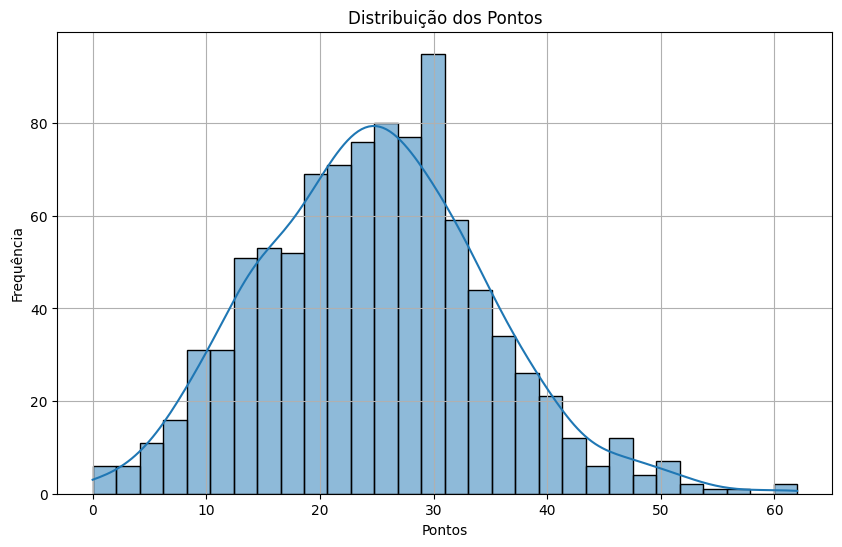

In [18]:
# Distribuição dos Pontos
plt.figure(figsize=(10, 6))
sns.histplot(df['PTS'], bins=30, kde=True)
plt.title('Distribuição dos Pontos')
plt.xlabel('Pontos')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

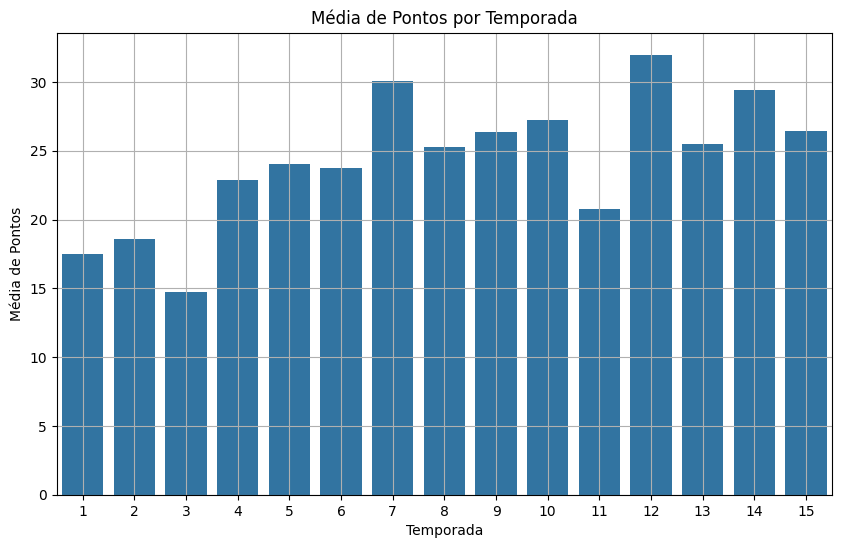

In [19]:
# Média de Pontos por Temporada
pontos_por_temporada = df.groupby('Temporada')['PTS'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Temporada', y='PTS', data=pontos_por_temporada)
plt.title('Média de Pontos por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Média de Pontos')
plt.grid(True)
plt.show()

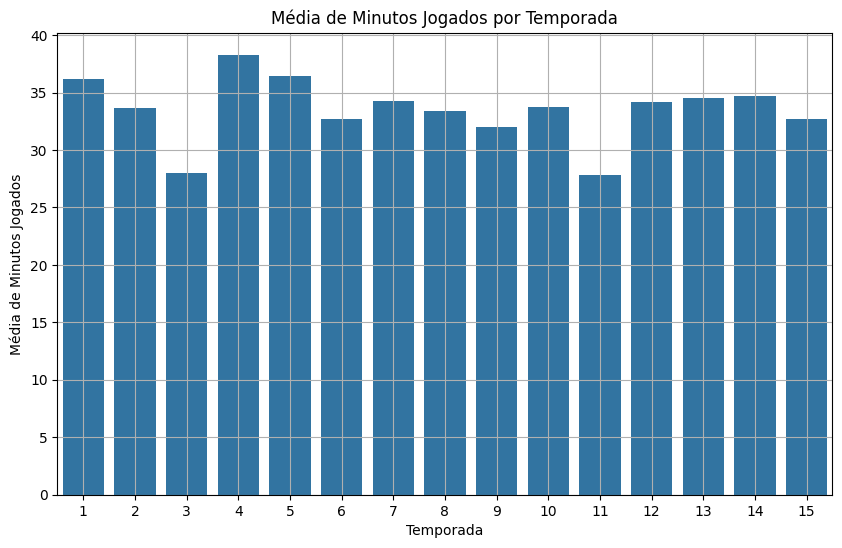

In [20]:
# Média de Minutos Jogados por Temporada
minutos_por_temporada = df.groupby('Temporada')['MP'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Temporada', y='MP', data=minutos_por_temporada)
plt.title('Média de Minutos Jogados por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Média de Minutos Jogados')
plt.grid(True)
plt.show()

In [21]:
minutos_por_dia_todas_temporada = df.groupby('Day_of_Week')['MP'].sum().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()

fig = px.bar(minutos_por_dia_todas_temporada, x='Day_of_Week', y='MP',
             title='Soma de Minutos Jogados por Dia da Semana - Todas As Temporada',
             labels={'Day_of_Week': 'Dia da Semana', 'MP': 'Soma de Minutos Jogados'})

# Exibir o gráfico
fig.show()

In [22]:
primeira_temporada = df[df['Temporada'] == df['Temporada'].unique().min()]

minutos_por_dia_primeira_temporada = primeira_temporada.groupby('Day_of_Week')['MP'].sum().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()

fig = px.bar(minutos_por_dia_primeira_temporada, x='Day_of_Week', y='MP',
             title='Soma de Minutos Jogados por Dia da Semana - Primeira Temporada',
             labels={'Day_of_Week': 'Dia da Semana', 'MP': 'Soma de Minutos Jogados'})

# Exibir o gráfico
fig.show()

In [23]:
quarta_temporada = df[df['Temporada'] == df['Temporada'].unique()[3]]

minutos_por_dia_quarta_temporada = quarta_temporada.groupby('Day_of_Week')['MP'].sum().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()

fig = px.bar(minutos_por_dia_quarta_temporada, x='Day_of_Week', y='MP',
             title='Soma de Minutos Jogados por Dia da Semana - Quarta Temporada',
             labels={'Day_of_Week': 'Dia da Semana', 'MP': 'Soma de Minutos Jogados'})

# Exibir o gráfico
fig.show()

In [24]:
ultima_temporada = df[df['Temporada'] == df['Temporada'].unique().max()]

minutos_por_dia_ultima_temporada = ultima_temporada.groupby('Day_of_Week')['MP'].sum().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()

fig = px.bar(minutos_por_dia_ultima_temporada, x='Day_of_Week', y='MP',
             title='Soma de Minutos Jogados por Dia da Semana - Última Temporada',
             labels={'Day_of_Week': 'Dia da Semana', 'MP': 'Soma de Minutos Jogados'})

# Exibir o gráfico
fig.show()

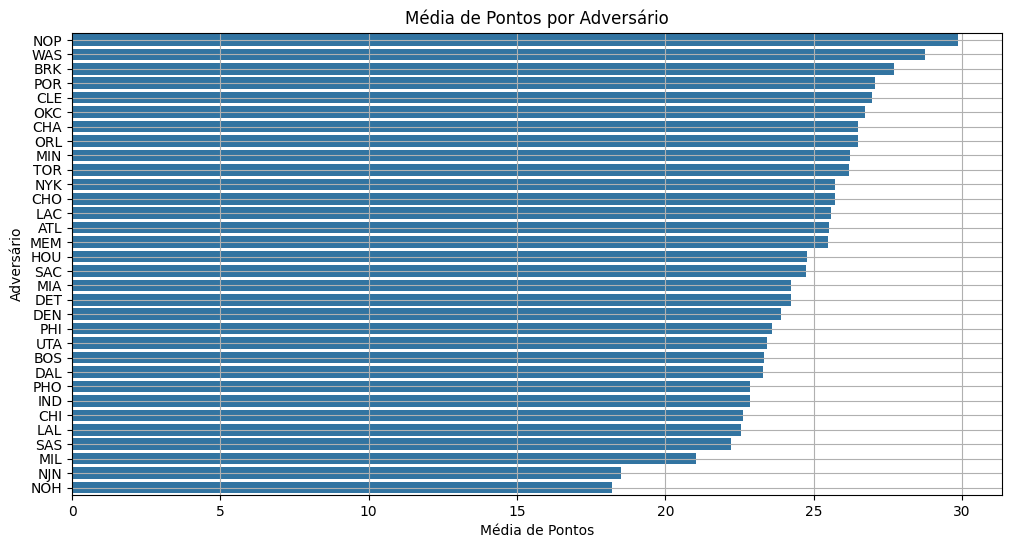

In [25]:
# Média de Pontos por Adversário
pontos_por_adversario = df.groupby('Opp')['PTS'].mean().reset_index()

pontos_por_adversario = pontos_por_adversario.sort_values(by='PTS', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x='PTS', y='Opp', data=pontos_por_adversario)
plt.title('Média de Pontos por Adversário')
plt.xlabel('Média de Pontos')
plt.ylabel('Adversário')
plt.grid(True)
plt.show()

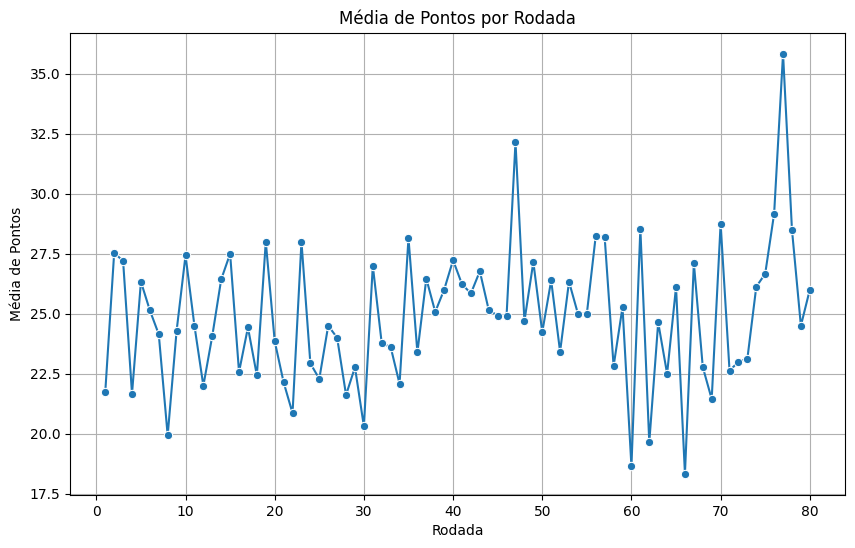

In [26]:
# Pontos por Rodada
pontos_por_rodada = df.groupby('Rodada')['PTS'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Rodada', y='PTS', data=pontos_por_rodada, marker='o')
plt.title('Média de Pontos por Rodada')
plt.xlabel('Rodada')
plt.ylabel('Média de Pontos')
plt.grid(True)
plt.show()

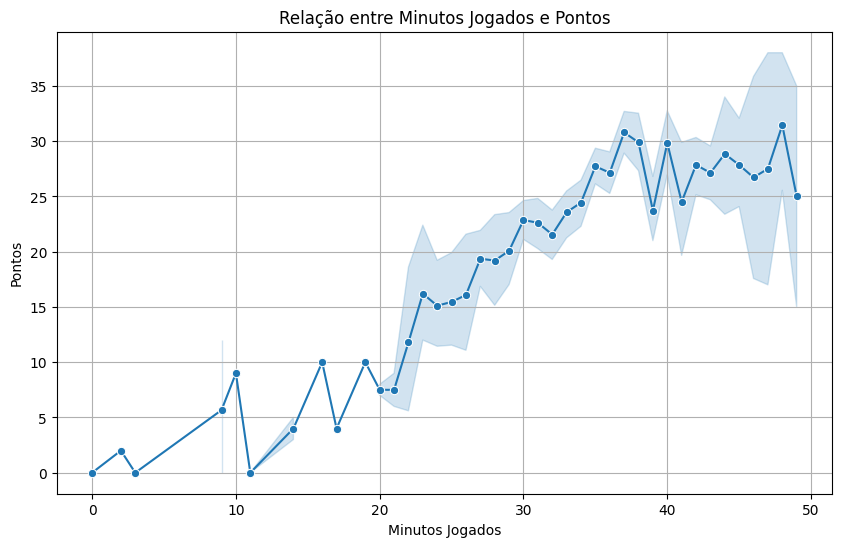

In [27]:
# Relação entre Minutos Jogados e Pontos
plt.figure(figsize=(10, 6))
sns.lineplot(x='MP', y='PTS', data=df, marker='o')
plt.title('Relação entre Minutos Jogados e Pontos')
plt.xlabel('Minutos Jogados')
plt.ylabel('Pontos')
plt.grid(True)
plt.show()

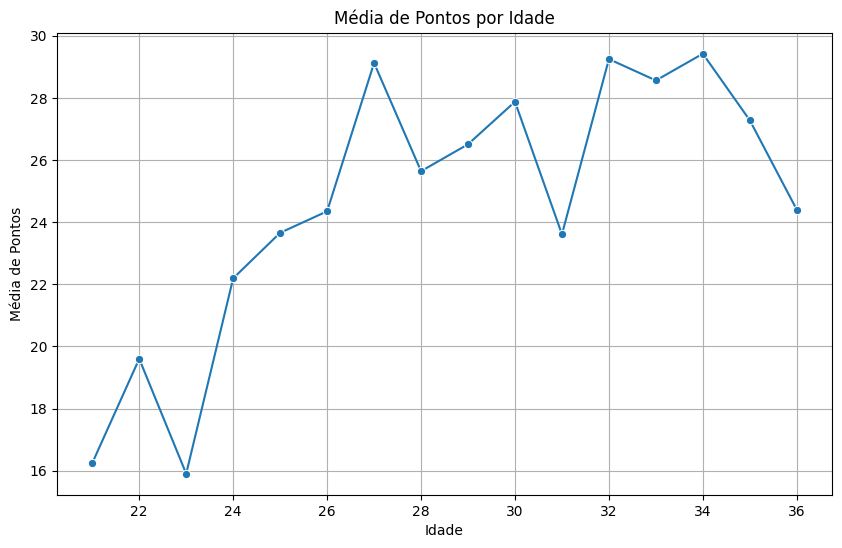

In [28]:
# Pontuação Média por Idade
pontos_por_idade = df.groupby('Age')['PTS'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Age', y='PTS', data=pontos_por_idade, marker='o')
plt.title('Média de Pontos por Idade')
plt.xlabel('Idade')
plt.ylabel('Média de Pontos')
plt.grid(True)
plt.show()

In [29]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
PTS,956.0,24.757322,0.0,18.0,25.0,31.0,62.0,9.952331
Date,956,2016-09-30 23:07:16.820083712,2009-10-28 00:00:00,2013-03-08 18:00:00,2016-03-13 00:00:00,2021-01-27 06:00:00,2024-04-12 00:00:00,NaN
Age,956.0,27.889121,21.0,24.0,27.5,32.0,36.0,4.378224
Local,956.0,0.492678,0.0,0.0,0.0,1.0,1.0,0.500208
MP,956.0,34.230126,0.0,31.0,35.0,37.0,49.0,5.847752
TRB,956.0,4.716527,0.0,3.0,5.0,6.0,14.0,2.430646
AST,956.0,6.400628,0.0,4.0,6.0,8.0,16.0,2.853777
STL,956.0,1.540795,0.0,1.0,1.0,2.0,7.0,1.29817
BLK,956.0,0.245816,0.0,0.0,0.0,0.0,3.0,0.514942
TOV,956.0,3.124477,0.0,2.0,3.0,4.0,11.0,1.815058


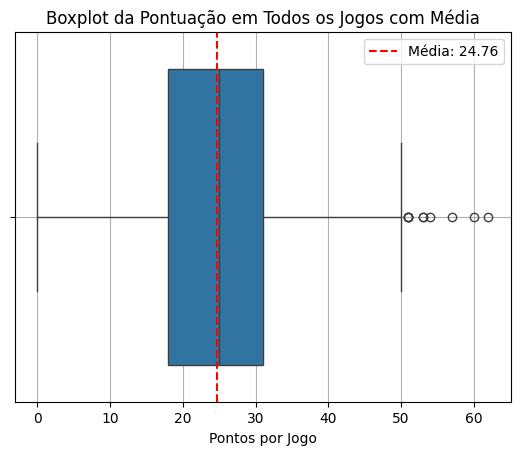

In [30]:

media_pontos = df['PTS'].mean()

sns.boxplot(x=df['PTS'])

#Linha da média
plt.axvline(media_pontos, color='r', linestyle='--', label=f'Média: {media_pontos:.2f}')

plt.title('Boxplot da Pontuação em Todos os Jogos com Média')
plt.xlabel('Pontos por Jogo')
plt.legend()
plt.grid(True)

plt.show()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_8040\935977685.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




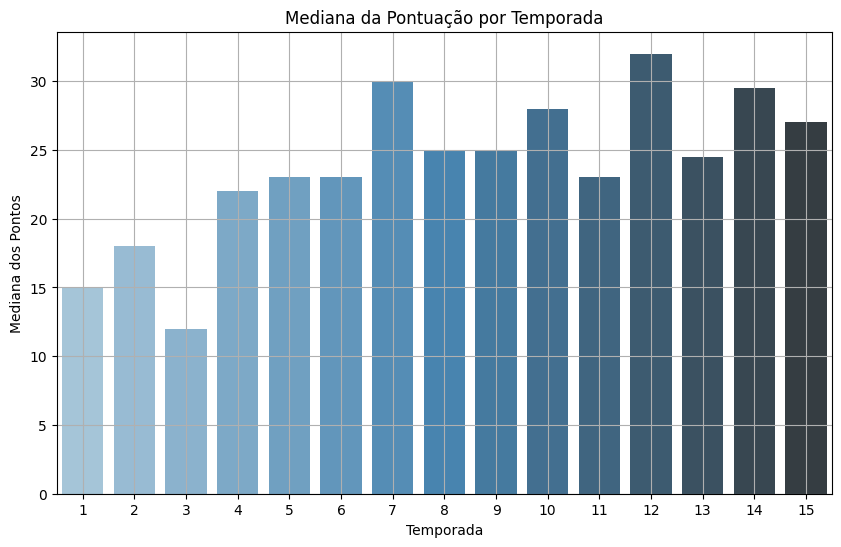

In [31]:
#Agrupar temporada e analisar mediana dos PTS
mediana_pontos_por_temporada = df.groupby('Temporada')['PTS'].median().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x='Temporada', y='PTS', data=mediana_pontos_por_temporada, palette='Blues_d')

plt.title('Mediana da Pontuação por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Mediana dos Pontos')
plt.grid(True)

plt.show()

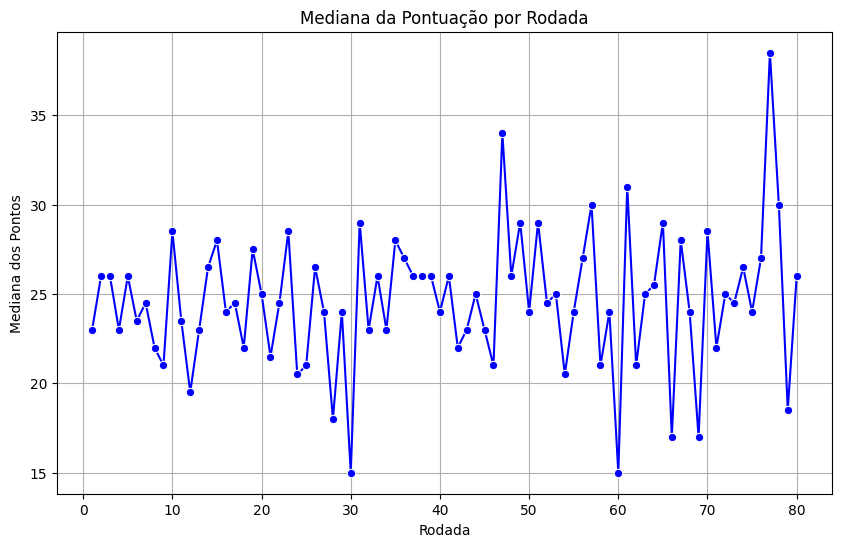

In [32]:
# Agrupar por rodada e analisar a mediana dos PTS
mediana_pontos_por_rodada = df.groupby('Rodada')['PTS'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Rodada', y='PTS', data=mediana_pontos_por_rodada, marker='o', color='blue')

plt.title('Mediana da Pontuação por Rodada')
plt.xlabel('Rodada')
plt.ylabel('Mediana dos Pontos')
plt.grid(True)

plt.show()


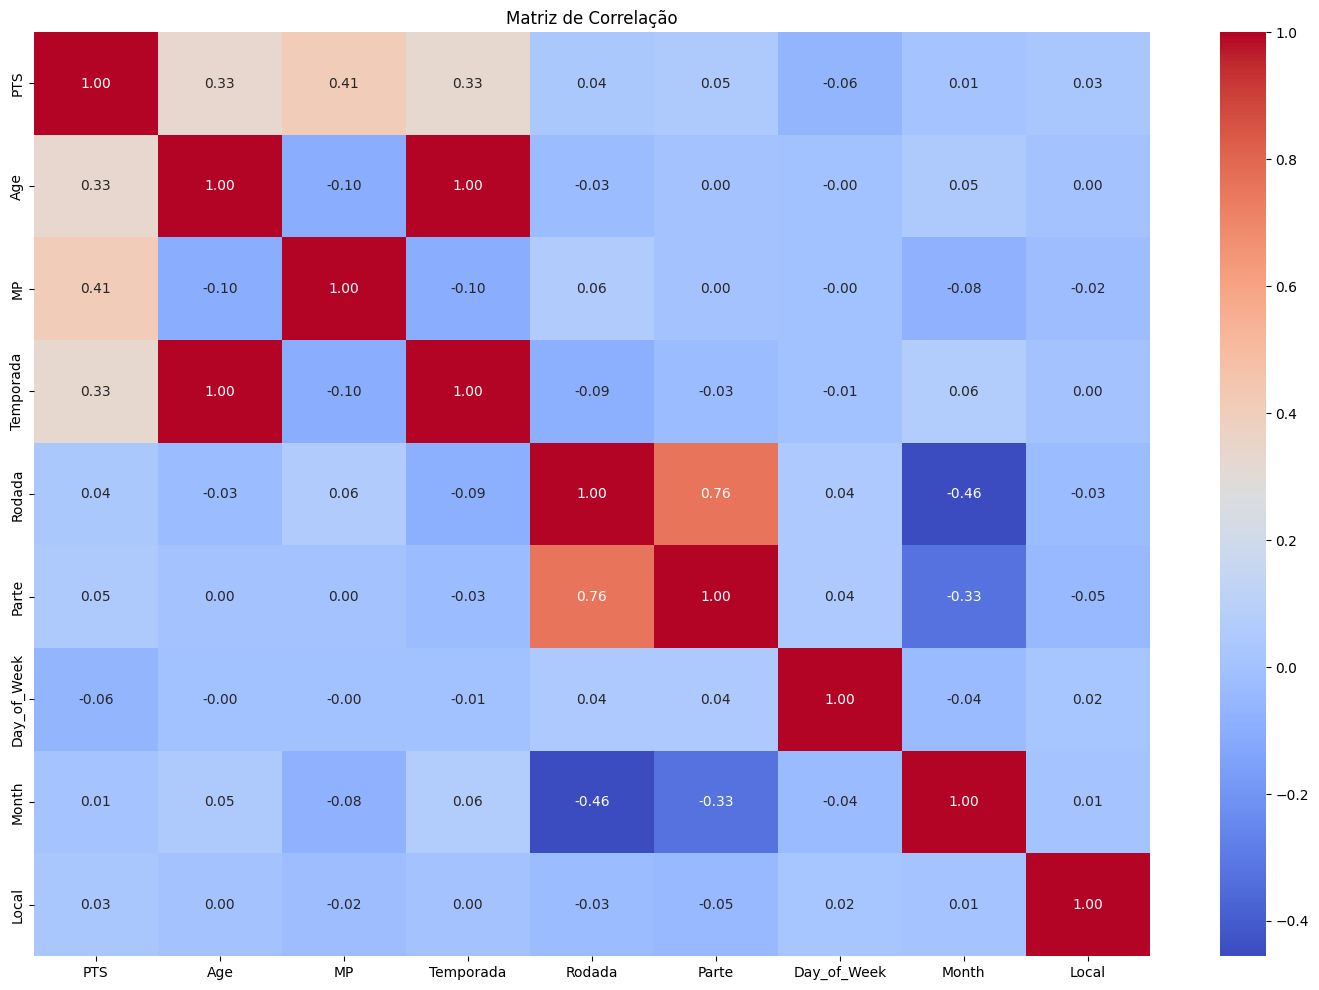

In [33]:
df['Day_of_Week'] = df['Day_of_Week'].astype('category').cat.codes
df['Month'] = df['Month'].astype('category').cat.codes
df['Local'] = df['Local'].astype('category').cat.codes


df_col_num = df[['PTS', 'Age', 'MP', 'Temporada', 'Rodada', 'Parte', 'Day_of_Week', 'Month', 'Local']]

corr_matrix = df_col_num.corr()

plt.figure(figsize=(18,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

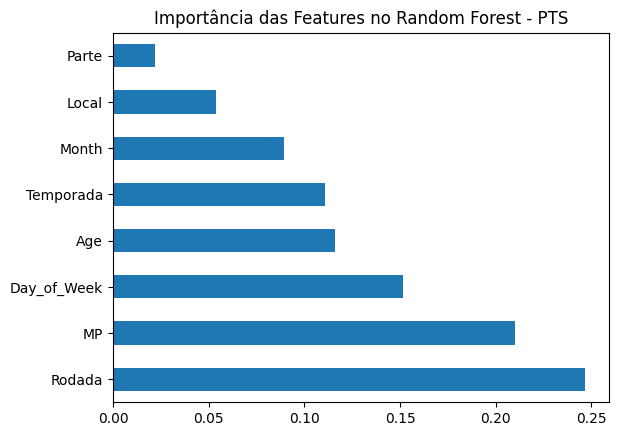

In [34]:
variaveis = ['MP', 'Local', 'Day_of_Week', 'Month', 'Age', 'Temporada', 'Rodada', 'Parte']  
X = df[variaveis]
y = df['PTS']


modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(X, y)


importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.nlargest(12).plot(kind='barh')
plt.title('Importância das Features no Random Forest - PTS')
plt.show()

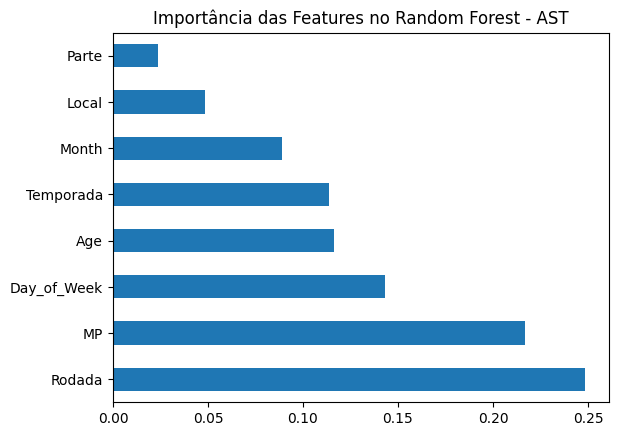

In [35]:
variaveis = ['MP', 'Local', 'Day_of_Week', 'Month', 'Age', 'Temporada', 'Rodada', 'Parte']  
X = df[variaveis]
y = df['AST']


modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(X, y)


importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.nlargest(12).plot(kind='barh')
plt.title('Importância das Features no Random Forest - AST')
plt.show()

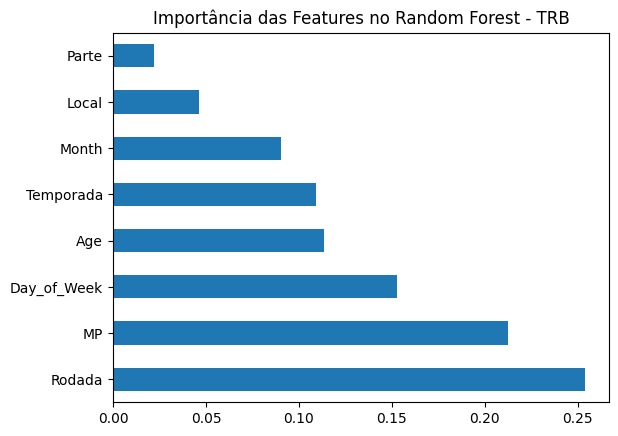

In [36]:
variaveis = ['MP', 'Local', 'Day_of_Week', 'Month', 'Age', 'Temporada', 'Rodada', 'Parte']  
X = df[variaveis]
y = df['TRB']


modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(X, y)


importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.nlargest(12).plot(kind='barh')
plt.title('Importância das Features no Random Forest - TRB')
plt.show()

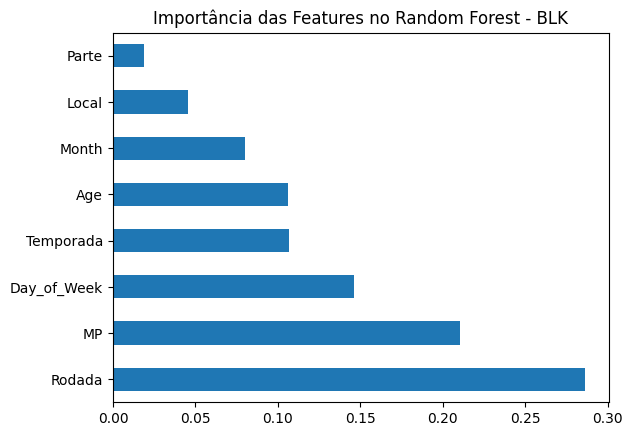

In [37]:
variaveis = ['MP', 'Local', 'Day_of_Week', 'Month', 'Age', 'Temporada', 'Rodada', 'Parte']  
X = df[variaveis]
y = df['BLK']


modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(X, y)


importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.nlargest(12).plot(kind='barh')
plt.title('Importância das Features no Random Forest - BLK')
plt.show()

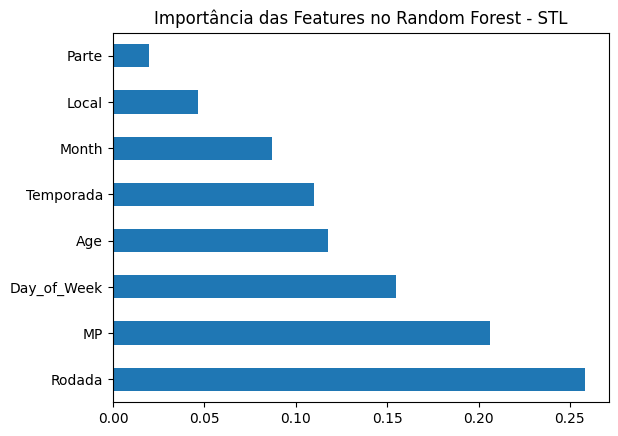

In [38]:
variaveis = ['MP', 'Local', 'Day_of_Week', 'Month', 'Age', 'Temporada', 'Rodada', 'Parte']  
X = df[variaveis]
y = df['STL']


modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(X, y)


importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.nlargest(12).plot(kind='barh')
plt.title('Importância das Features no Random Forest - STL')
plt.show()

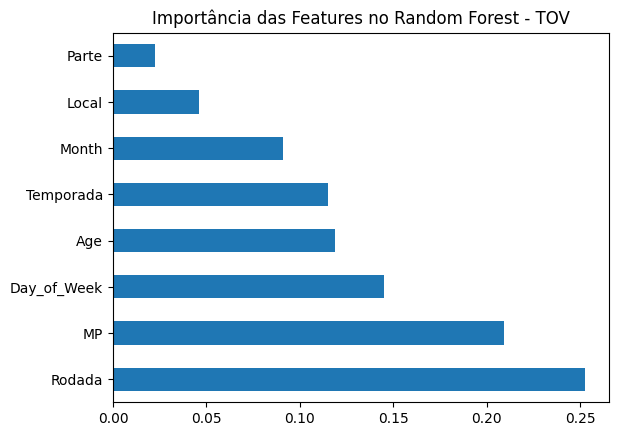

In [39]:
variaveis = ['MP', 'Local', 'Day_of_Week', 'Month', 'Age', 'Temporada', 'Rodada', 'Parte']  
X = df[variaveis]
y = df['TOV']


modelo = RandomForestClassifier(n_estimators=100)
modelo.fit(X, y)


importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.nlargest(12).plot(kind='barh')
plt.title('Importância das Features no Random Forest - TOV')
plt.show()

In [124]:
features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'MP', 'Temporada', 'Rodada']),
        ('cat', OneHotEncoder(), ['Opp', 'Local', 'Day_of_Week', 'Month'])
    ])


kmeans = KMeans(n_clusters=3, random_state=42)


pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])


pipeline.fit(df[features])

df['Cluster'] = pipeline.predict(df[features])


features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']
target = 'PTS'  


X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'MP', 'Temporada', 'Rodada']),
        ('cat', OneHotEncoder(), ['Opp', 'Local', 'Day_of_Week', 'Month'])
    ])


model = RandomForestRegressor(random_state=42, n_estimators=100)


pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


results = pd.DataFrame({'Real': y_test, 'Previsto': y_pred})
print(results.head())


MAE: 6.25
RMSE: 8.06
     Real  Previsto
758    16     24.01
398    27     20.26
688    19     22.21
137    35     32.42
469    25     28.93


In [125]:
# analisar retiradas de temporadas df = df[df['Temporada'] != 11]

df = df.sort_values(by=['Date'])


features = ['Age', 'MP', 'Opp', 'Rodada', 'Parte', 'Temporada', 'Day_of_Week', 'Local', 'Month']
target = 'PTS'


train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]




X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features ]
y_test = test_data[target]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'MP', 'Rodada', 'Temporada', 'Parte']),
        ('cat', OneHotEncoder(), ['Opp', 'Day_of_Week', 'Month', 'Local'])  
    ])


model = RandomForestRegressor()


param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10] 
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', grid_search)])


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


results = pd.DataFrame({'Real': y_test, 'Previsto': y_pred})
print(results.head())


MAE: 7.83
RMSE: 9.67
     Real   Previsto
393    27  31.428404
551    23  28.963421
125    36  39.882337
659    20  29.965362
798    15  28.312921


In [98]:

features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']
target = 'PTS'  

train_size = int(0.8 * len(df))  
# X_train = df[features].iloc[:train_size]
# y_train = df[target].iloc[:train_size]
# X_test = df[features].iloc[train_size:]
# y_test = df[target].iloc[train_size:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['MP']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Opp', 'Local', 'Day_of_Week', 'Month', 'Temporada', 'Rodada', 'Age'])
    ])

model_rf = RandomForestRegressor(random_state=42, n_estimators=250)#analisar isso
model_lr = LinearRegression()

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_rf)])
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_lr)])

pipeline_rf.fit(X_train, y_train)
pipeline_lr.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test)
y_pred_lr = pipeline_lr.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mae_rf)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mae_lr)

print(f'Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}')
print(f'Linear Regression - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}')


Random Forest - MAE: 7.29, RMSE: 2.70
Linear Regression - MAE: 7.83, RMSE: 2.80


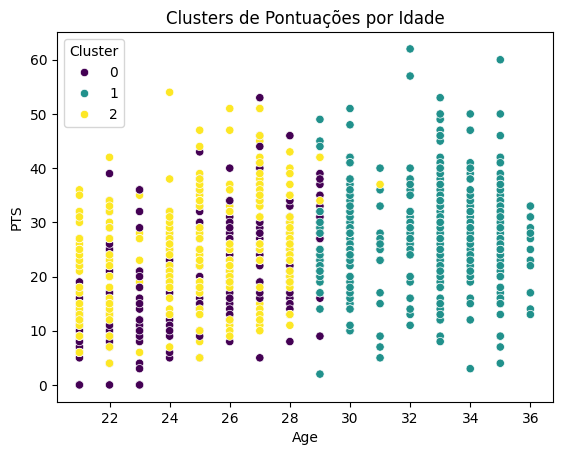

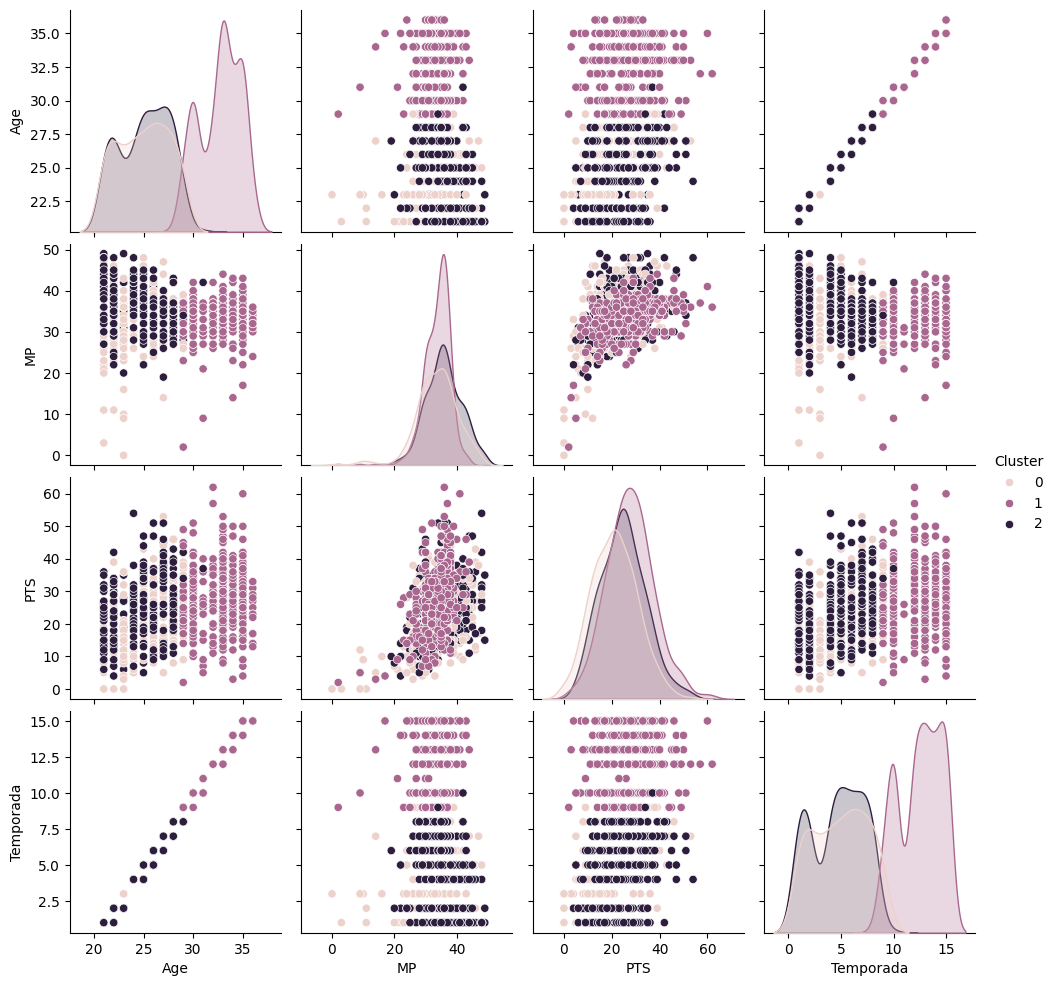

In [42]:
features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'MP', 'Temporada', 'Rodada']),
        ('cat', OneHotEncoder(), ['Opp', 'Local', 'Day_of_Week', 'Month'])
    ])


kmeans = KMeans(n_clusters=3, random_state=42)


pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])


pipeline.fit(df[features])


df['Cluster'] = pipeline.predict(df[features])


sns.scatterplot(data=df, x='Age', y='PTS', hue='Cluster', palette='viridis')
plt.title('Clusters de Pontuações por Idade')
plt.show()

sns.pairplot(df, hue='Cluster', vars=['Age', 'MP', 'PTS', 'Temporada'])
plt.show()


RMSE do modelo: 10.52


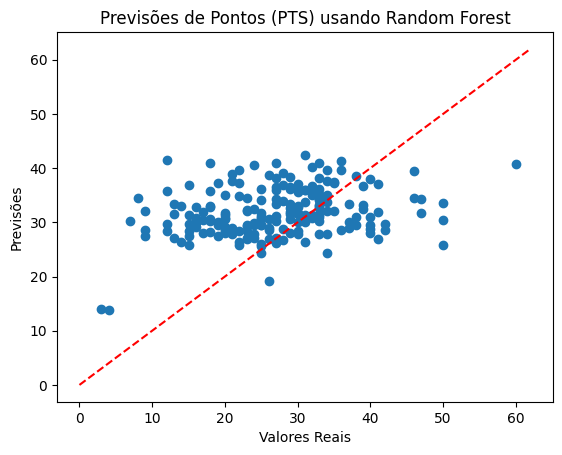

In [81]:
features = ['Age', 'MP', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month', 'Cluster']
X = df[features]
y = df['PTS']


train_size = int(0.8 * len(df))  
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]


rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"RMSE do modelo: {rmse:.2f}")


plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões de Pontos (PTS) usando Random Forest')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  
plt.show()


# CUIDADO COM A CÉLULA ABAIXO ! ! ! ! ! ! ! ! ! ! 

#### A célula abaixo faz um cross-validation e retorna os melhores parâmetros para o GradientBoostingRegressor

#### Porém, quando a executei, a temperatura do meu processador chegou a **95°C**. Então a execute somente em casos de muita necessidade.

In [153]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Defina o modelo básico
gbr = GradientBoostingRegressor(random_state=42)

# Defina a grade de hiperparâmetros
param_grid = {
    'n_estimators': [500, 1000, 1500, 1750, 2000],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.05],
    'subsample': [0.6, 0.8, 0.9]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['MP']),
        ('cat', OneHotEncoder(), ['Opp', 'Local', 'Day_of_Week', 'Month', 'Temporada', 'Rodada', 'Age'])
    ])

# Defina o GridSearchCV
model = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

# Exibe os melhores parâmetros e score
print("Melhores parâmetros:", model.best_params_)
print("Melhor score:", model.best_score_)


Fitting 5 folds for each of 180 candidates, totalling 900 fits
Melhores parâmetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}
Melhor score: -66.61259649896968


#### Provavelmente o modelo com o melhor desempenho

#### Usei o GradientBoostingRegressor com os seguintes hiper-parâmetros para Pontos:
- n_estimators: 200
- max_depth: 7
- subsample: 0.6
- learning_rate: 0.01

#### Obtendo os seguintes resultados para Pontos:
- MAE (Treino): 4.7399
- MAE (Teste): 6.9982

##### Obs: Eu testei removendo a temporada 3 e 11 e cada uma delas separadamente, porém o modelo teve um desempenho levemente inferior.

In [149]:
from sklearn.ensemble import GradientBoostingRegressor

features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']
target = 'PTS'  

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['MP']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Opp', 'Local', 'Day_of_Week', 'Month', 'Temporada', 'Rodada', 'Age'])
    ])

model = GradientBoostingRegressor(n_estimators=200, max_depth=7, subsample=0.6, random_state=42, learning_rate=0.01)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test_pts = pipeline.predict(X_test)

# Calculando as métricas para o conjunto de treino
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mae_train)

# Calculando as métricas para o conjunto de teste
mae_test = mean_absolute_error(y_test, y_pred_test_pts)
rmse_test = np.sqrt(mae_test)

print("Métricas para o conjunto de treino - Pontos:")
print(f"MAE (Treino): {mae_train:.4f}")
print(f"RMSE (Treino): {rmse_train:.4f}")

print("\nMétricas para o conjunto de teste - Pontos:")
print(f"MAE (Teste): {mae_test:.4f}")
print(f"RMSE (Teste): {rmse_test:.4f}")

Métricas para o conjunto de treino - Pontos:
MAE (Treino): 4.7399
RMSE (Treino): 2.1771

Métricas para o conjunto de teste - Pontos:
MAE (Teste): 6.9982
RMSE (Teste): 2.6454


#### Usado o GradientBoostingRegressor com os seguintes hiper-parâmetros para Assistência:
- n_estimators: 200
- max_depth: 3
- subsample: 0.6
- learning_rate: 0.01

#### Obtendo os seguintes resultados para Assistência:
- MAE (Treino): 1.9941
- MAE (Teste): 2.2286

In [115]:
from sklearn.ensemble import GradientBoostingRegressor

features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']
target = 'AST'  

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['MP']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Opp', 'Local', 'Day_of_Week', 'Month', 'Temporada', 'Rodada', 'Age'])
    ])

model = GradientBoostingRegressor(n_estimators=200, max_depth=3, subsample=0.6, random_state=42, learning_rate=0.01)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test_ast = pipeline.predict(X_test)

# Calculando as métricas para o conjunto de treino
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mae_train)

# Calculando as métricas para o conjunto de teste
mae_test = mean_absolute_error(y_test, y_pred_test_ast)
rmse_test = np.sqrt(mae_test)

print("Métricas para o conjunto de treino - Assistência:")
print(f"MAE (Treino): {mae_train:.4f}")
print(f"RMSE (Treino): {rmse_train:.4f}")

print("\nMétricas para o conjunto de teste - Assistência:")
print(f"MAE (Teste): {mae_test:.4f}")
print(f"RMSE (Teste): {rmse_test:.4f}")

Métricas para o conjunto de treino - Assistência:
MAE (Treino): 1.9941
RMSE (Treino): 1.4121

Métricas para o conjunto de teste - Assistência:
MAE (Teste): 2.2286
RMSE (Teste): 1.4929


#### Usado o GradientBoostingRegressor com os seguintes hiper-parâmetros para Rebotes:
- n_estimators: 200
- max_depth: 3
- subsample: 0.6
- learning_rate: 0.01

#### Obtendo os seguintes resultados para Rebotes:
- MAE (Treino): 1.7078
- MAE (Teste): 2.0380

In [118]:
from sklearn.ensemble import GradientBoostingRegressor

features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']
target = 'TRB'  

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['MP']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Opp', 'Local', 'Day_of_Week', 'Month', 'Temporada', 'Rodada', 'Age'])
    ])

model = GradientBoostingRegressor(n_estimators=200, max_depth=3, subsample=0.6, random_state=42, learning_rate=0.01)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test_trb = pipeline.predict(X_test)

# Calculando as métricas para o conjunto de treino
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mae_train)

# Calculando as métricas para o conjunto de teste
mae_test = mean_absolute_error(y_test, y_pred_test_trb)
rmse_test = np.sqrt(mae_test)

print("Métricas para o conjunto de treino - Rebotes:")
print(f"MAE (Treino): {mae_train:.4f}")
print(f"RMSE (Treino): {rmse_train:.4f}")

print("\nMétricas para o conjunto de teste - Rebotes:")
print(f"MAE (Teste): {mae_test:.4f}")
print(f"RMSE (Teste): {rmse_test:.4f}")

Métricas para o conjunto de treino - Rebotes:
MAE (Treino): 1.7078
RMSE (Treino): 1.3068

Métricas para o conjunto de teste - Rebotes:
MAE (Teste): 2.0380
RMSE (Teste): 1.4276


#### Usado o GradientBoostingRegressor com os seguintes hiper-parâmetros para Bloqueios:
- n_estimators: 200
- max_depth: 3
- subsample: 0.6
- learning_rate: 0.01

#### Obtendo os seguintes resultados para Bloqueios:
- MAE (Treino): 0.3265
- MAE (Teste): 0.4401

In [122]:
from sklearn.ensemble import GradientBoostingRegressor

features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']
target = 'BLK'  

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['MP']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Opp', 'Local', 'Day_of_Week', 'Month', 'Temporada', 'Rodada', 'Age'])
    ])

model = GradientBoostingRegressor(n_estimators=200, max_depth=3, subsample=0.6, random_state=42, learning_rate=0.01)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test_blk = pipeline.predict(X_test)

# Calculando as métricas para o conjunto de treino
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mae_train)

# Calculando as métricas para o conjunto de teste
mae_test = mean_absolute_error(y_test, y_pred_test_blk)
rmse_test = np.sqrt(mae_test)

print("Métricas para o conjunto de treino - Bloqueio:")
print(f"MAE (Treino): {mae_train:.4f}")
print(f"RMSE (Treino): {rmse_train:.4f}")

print("\nMétricas para o conjunto de teste - Bloqueio:")
print(f"MAE (Teste): {mae_test:.4f}")
print(f"RMSE (Teste): {rmse_test:.4f}")

Métricas para o conjunto de treino - Bloqueio:
MAE (Treino): 0.3265
RMSE (Treino): 0.5714

Métricas para o conjunto de teste - Bloqueio:
MAE (Teste): 0.4401
RMSE (Teste): 0.6634


#### Usado o GradientBoostingRegressor com os seguintes hiper-parâmetros para Turnover:
- n_estimators: 250
- max_depth: 3
- subsample: 0.6
- learning_rate: 0.01

#### Obtendo os seguintes resultados para Turnover:
- MAE (Treino): 1.3455
- MAE (Teste): 1.2954

In [127]:
from sklearn.ensemble import GradientBoostingRegressor

features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']
target = 'TOV'  

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['MP']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Opp', 'Local', 'Day_of_Week', 'Month', 'Temporada', 'Rodada', 'Age'])
    ])

model = GradientBoostingRegressor(n_estimators=200, max_depth=3, subsample=0.6, random_state=42, learning_rate=0.01)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test_tov = pipeline.predict(X_test)

# Calculando as métricas para o conjunto de treino
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mae_train)

# Calculando as métricas para o conjunto de teste
mae_test = mean_absolute_error(y_test, y_pred_test_tov)
rmse_test = np.sqrt(mae_test)

print("Métricas para o conjunto de treino - Turnovers:")
print(f"MAE (Treino): {mae_train:.4f}")
print(f"RMSE (Treino): {rmse_train:.4f}")

print("\nMétricas para o conjunto de teste - Turnovers:")
print(f"MAE (Teste): {mae_test:.4f}")
print(f"RMSE (Teste): {rmse_test:.4f}")

Métricas para o conjunto de treino - Turnovers:
MAE (Treino): 1.3455
RMSE (Treino): 1.1600

Métricas para o conjunto de teste - Turnovers:
MAE (Teste): 1.2954
RMSE (Teste): 1.1382


#### Usado o GradientBoostingRegressor com os seguintes hiper-parâmetros para Roubo de Bola:
- n_estimators: 250
- max_depth: 3
- subsample: 0.6
- learning_rate: 0.01

#### Obtendo os seguintes resultados para Roubo de Bola:
- MAE (Treino): 0.7905
- MAE (Teste): 1.0466

In [138]:
from sklearn.ensemble import GradientBoostingRegressor

features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']
target = 'STL'  

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['MP']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Opp', 'Local', 'Day_of_Week', 'Month', 'Temporada', 'Rodada', 'Age'])
    ])

model = GradientBoostingRegressor(n_estimators=1750, max_depth=3, subsample=0.6, random_state=42, learning_rate=0.01)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test_stl = pipeline.predict(X_test)

# Calculando as métricas para o conjunto de treino
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mae_train)

# Calculando as métricas para o conjunto de teste
mae_test = mean_absolute_error(y_test, y_pred_test_stl)
rmse_test = np.sqrt(mae_test)

print("Métricas para o conjunto de treino - Roubo de bola:")
print(f"MAE (Treino): {mae_train:.4f}")
print(f"RMSE (Treino): {rmse_train:.4f}")

print("\nMétricas para o conjunto de teste - Roubo de bola:")
print(f"MAE (Teste): {mae_test:.4f}")
print(f"RMSE (Teste): {rmse_test:.4f}")

Métricas para o conjunto de treino - Roubo de bola:
MAE (Treino): 0.7905
RMSE (Treino): 0.8891

Métricas para o conjunto de teste - Roubo de bola:
MAE (Teste): 1.0466
RMSE (Teste): 1.0231


#### Eu pesquisei as médias do Curry na temporada 2023-2024. Peguei os valores previstos equivalente à temporada de 2023-2024, calculei a média e comparei para trazer uma noção sobre o desempenho do modelo

In [147]:
qtd = 74
pts = y_pred_test_pts[-qtd:].mean()
ast = y_pred_test_ast[-qtd:].mean()
blk = y_pred_test_blk[-qtd:].mean()
trb = y_pred_test_trb[-qtd:].mean()
tov = y_pred_test_tov[-qtd:].mean()
stl = y_pred_test_stl[-qtd:].mean()

pts_2024_real = 26.4
ast_2024_real = 5.1
trb_2024_real = 4.5
blk_2024_real = 0.4
stl_2024_real = 0.7
tov_2024_real = 2.8

print("Relação entre as médias das estatísticas de 2024:")
print("Real - Previsto")
print(f"PTS: {pts_2024_real:.2f} - {pts:.2f}")
print(f"AST: {ast_2024_real:.2f} - {ast:.2f}")
print(f"REB: {trb_2024_real:.2f} - {trb:.2f}")
print(f"BLK: {blk_2024_real:.2f} - {blk:.2f}")
print(f"STL: {stl_2024_real:.2f} - {stl:.2f}")
print(f"TOV: {tov_2024_real:.2f} - {tov:.2f}")


Relação entre as médias das estatísticas de 2024:
Real - Previsto
PTS: 26.40 - 23.29
AST: 5.10 - 6.32
REB: 4.50 - 4.53
BLK: 0.40 - 0.21
STL: 0.70 - 1.57
TOV: 2.80 - 3.12


#### Fiz o silhouette_score para verificar a viabilidade de usar algoritmos de clustering.

#### O maior resultado foi para o **número de cluster = 17** marcando um **score = 0.091898**. Ou seja, como o score é próximo de 0, temos que os clusters não tem limites bem definidos. Sendo assim, um modelo provalmente ineficiente.

In [172]:
scaler = StandardScaler()

features = ['Age', 'MP', 'Opp', 'Temporada', 'Rodada', 'Local', 'Day_of_Week', 'Month']
X = df[features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['MP']),
        ('cat', OneHotEncoder(sparse_output=False), ['Opp', 'Local', 'Day_of_Week', 'Month', 'Temporada', 'Rodada', 'Age'])
    ])

X_scaled = preprocessor.fit_transform(X)
k_list = np.arange(start=2, stop=df.shape[0]-1, step=1)

silhouette_scores_data = pd.DataFrame()

for k_trial in k_list:
    db = AgglomerativeClustering(linkage="ward", n_clusters=k_trial)
    
    if len(np.unique(db.fit_predict(X_scaled))):
        sil_score = silhouette_score(X_scaled, db.fit_predict(X_scaled))
    else:
        continue
    
    trial_parameters = "K: " + str(k_trial)
    
    # Usando pd.concat() em vez de append()
    silhouette_scores_data = pd.concat([silhouette_scores_data, pd.DataFrame(data=[[sil_score, trial_parameters]], columns=["score", "parameters"])], ignore_index=True)

silhouette_scores_data.sort_values(by='score', ascending=False).head()


,score,parameters
15,0.091898,K: 17
16,0.091414,K: 18
17,0.090983,K: 19
14,0.089028,K: 16
21,0.085762,K: 23


In [37]:
df.to_csv('dados_alterados.csv', index=False) 